# MIT-GSL Uruguay 

## January 2020

-----

# Week - 2 | Lesson - 03 
# NLP: Product embeddings

1. After introducing the concept of embeddings through NLP, we extend the notion of embeddings to other settings
2. Note that embeddings are dense continuous representations for discrete, sparse tokens - this makes embeddings widely applicable
3. We will use the concept of embeddings to understand the world of e-commerce better 

---

# Word2Vec and its Applications to Market-Basket Data

# Instacart Grocery Dataset

### Source: https://www.instacart.com/datasets/grocery-shopping-2017

1. Instacart is an online grocery delivery service
2. They have made available 3M grocery orders for over 200K users
3. They provide between 4 to 100 orders for each user and each order contains the sequence of products purchased
4. We also have a brief description of the products

### Overview:
1. We will use this data to build an understanding of word embeddings and investigate their application to downstream tasks
2. For this purpose, we will consider each purchase basket to be a sentence with an unordered sequence of words

---

# 0. Import Modules

In [13]:
# ==============================================
# 0. Module imports
# ==============================================

import pandas as pd
pd.options.display.max_colwidth = 100
import numpy as np
from itertools import product
import csv

# w2v
import gensim

# text processing
from nltk import sent_tokenize, word_tokenize
from nltk.tokenize import ToktokTokenizer
import string
import re # regular expressions
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity

# T-Sne
#import umap
#from openTSNE import TSNE, TSNEEmbedding, affinity, initialization
#from openTSNE import initialization
#from openTSNE.callbacks import ErrorLogger
from sklearn.manifold import TSNE


# utils
from sklearn import utils


# parallel processing
import multiprocessing
from joblib import delayed, Parallel

# time code
import time

# 2-d visualiztion
%matplotlib inline
from ggplot import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import os
# os.chdir("/pool001/madhavk/gsl-uruguay/W-02-NLP/")

In [14]:
# =========================================================
# set directories
# =========================================================

import os
EC2 = True  # If using EC2 (for data directory/paths)

# Select path based off of local or remote
if not EC2:
    wd = "/pool001/madhavk/gsl-uruguay/W-02-NLP/"
else:
    wd = "/home/ubuntu/machine_learning_aws/"
os.chdir(wd)

EC2 = True  # If using EC2 (for data directory/paths)
if not EC2:
    # raw data
    raw_data_dir = "nlp-data/in-grocery/instacart_2017_05_01/"
    # processed data
    process_dir = "nlp-data/in-grocery/prepared-data/"  
else:
    # raw data
    raw_data_dir = "data/in-grocery/instacart_2017_05_01"
    # processed data
    process_dir = "data/in-grocery/prepared-data/"

In [15]:
# =========================================================
# processed files
# =========================================================

os.listdir(process_dir)

['orders-split-v1.csv',
 'all-orders-wide-v1.csv',
 'all-orders-long-v1.csv',
 'products-merged-v1.csv']

In [16]:
# =========================================================
# global parameters
# =========================================================

# show entire value of cell in pandas
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 500)

# number of cpus
cpus = multiprocessing.cpu_count()
f"Number of CPUs: {cpus}"

'Number of CPUs: 4'

------

# 1. Import grocery data

## 1.1. Order level data

In [17]:
# =========================================================
# order-level data
# =========================================================

orders_wide = pd.read_csv(process_dir + "all-orders-wide-v1.csv")
# This data set has one row per order with the products ordered in the product_id column. 
# Products are separated by space.
print(orders_wide.shape)

(3152555, 4)


In [18]:
display(orders_wide.head(10))

,order_id,product_id,num_products,eval
0,2,33120 28985 9327 45918 30035 17794 40141 1819,8,prior
1,3,33754 24838 17704 21903 17668 46667 17461 32665,8,prior
2,4,46842 39758 27761 10054 21351 22598 34862 40285 17616 25146 32645 41276,12,prior
3,5,13176 47329 27966 23909 48370 13245 27360 6348 40878 6184 48002 20914 37011 12962 45698 41176 48366 47209 46522 38693 48825 8479,22,prior
4,7,34050 46802,2,prior
5,9,21405 47890 11182 2014 29193 34203 14992 31506 23288 44533 18362 432 3990 14183,14,prior
6,10,24852 4796 31717 47766 4605 1529 21137 22122 34134 27156 14992 49235 26842 3464 25720,15,prior
7,11,30162 5994 1313 31506,4,prior
8,12,30597 15221 43772 37886 37215 34335 26910 38888 38050 29471,10,prior
9,13,17330 27407 35419 196 44635 26878 25783 41290 33198 23020 36086 3800 25952,13,prior


In [19]:
# =========================================================
# orders meta-data
# =========================================================

orders_meta = pd.read_csv(process_dir + "orders-split-v1.csv")
# This dataset includes the meta data for each order, i.e., the user who ordered it, order day of the week, order time
print(orders_meta.shape)

(3346083, 7)


In [20]:
display(orders_meta.head(10))

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,eval
0,2539329,1,1,2,8,NaN,prior
1,2398795,1,2,3,7,15.0,prior
2,473747,1,3,3,12,21.0,prior
3,2254736,1,4,4,7,29.0,prior
4,431534,1,5,4,15,28.0,prior
5,3367565,1,6,2,7,19.0,prior
6,550135,1,7,1,9,20.0,prior
7,3108588,1,8,1,14,14.0,prior
8,2295261,1,9,1,16,0.0,prior
9,2550362,1,10,4,8,30.0,prior


----

## 1.2. Merge train-val-test split

In [21]:
# =========================================================
# merge orders-wide and orders-meta
# =========================================================

orders_wide.drop(labels = "eval", axis = 1, inplace = True)
orders_wide = pd.merge(orders_wide, # data - 1
                       orders_meta[["order_id", "user_id", "eval"]], # data - 2
                       on = "order_id", # merge key
                       how = "left") # left join
print(orders_wide.shape)

(3152555, 5)


In [22]:
display(orders_wide.head(10))

,order_id,product_id,num_products,user_id,eval
0,2,33120 28985 9327 45918 30035 17794 40141 1819,8,202279,prior
1,3,33754 24838 17704 21903 17668 46667 17461 32665,8,205970,prior
2,4,46842 39758 27761 10054 21351 22598 34862 40285 17616 25146 32645 41276,12,178520,prior
3,5,13176 47329 27966 23909 48370 13245 27360 6348 40878 6184 48002 20914 37011 12962 45698 41176 48366 47209 46522 38693 48825 8479,22,156122,prior
4,7,34050 46802,2,142903,prior
5,9,21405 47890 11182 2014 29193 34203 14992 31506 23288 44533 18362 432 3990 14183,14,139016,prior
6,10,24852 4796 31717 47766 4605 1529 21137 22122 34134 27156 14992 49235 26842 3464 25720,15,135442,prior
7,11,30162 5994 1313 31506,4,143742,prior
8,12,30597 15221 43772 37886 37215 34335 26910 38888 38050 29471,10,152610,prior
9,13,17330 27407 35419 196 44635 26878 25783 41290 33198 23020 36086 3800 25952,13,45082,prior


In [23]:
# =========================================================
# eval-set distribution
# =========================================================

orders_wide["eval"].value_counts()

prior    2959079
train    116333 
val      38701  
test     38442  
Name: eval, dtype: int64

In [24]:
# clear some space
del orders_meta

----

## 1.3. Import product info data

In [25]:
products = pd.read_csv(process_dir + "products-merged-v1.csv")
print(products.shape)

(49688, 6)


In [26]:
display(products.head(10))

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry
5,6,Dry Nose Oil,11,11,cold flu allergy,personal care
6,7,Pure Coconut Water With Orange,98,7,juice nectars,beverages
7,8,Cut Russet Potatoes Steam N' Mash,116,1,frozen produce,frozen
8,9,Light Strawberry Blueberry Yogurt,120,16,yogurt,dairy eggs
9,10,Sparkling Orange Juice & Prickly Pear Beverage,115,7,water seltzer sparkling water,beverages


In [27]:
#===============================================
# top departments
#===============================================
products["department"].value_counts()

personal care      6563
snacks             6264
pantry             5371
beverages          4365
frozen             4007
dairy eggs         3449
household          3085
canned goods       2092
dry goods pasta    1858
produce            1684
bakery             1516
deli               1322
missing            1258
international      1139
breakfast          1115
babies             1081
alcohol            1054
pets               972 
meat seafood       907 
other              548 
bulk               38  
Name: department, dtype: int64

-----

### In-class exercise

In [28]:
#===============================================
# top aisles
#===============================================
# can you figure out which aisles host the most number of products?
products["aisle"].value_counts()

missing                          1258
candy chocolate                  1246
ice cream ice                    1091
vitamins supplements             1038
yogurt                           1026
chips pretzels                   989 
tea                              894 
packaged cheese                  891 
frozen meals                     880 
cookies cakes                    874 
energy granola bars              832 
hair care                        816 
spices seasonings                797 
juice nectars                    792 
crackers                         747 
soup broth bouillon              737 
baby food formula                718 
coffee                           680 
refrigerated                     675 
cleaning products                655 
baking ingredients               623 
packaged vegetables fruits       615 
asian foods                      605 
nuts seeds dried fruit           582 
fresh vegetables                 569 
oral hygiene                     565 
salad dressi

---

# 2. Data exploration

In [29]:
# long-form of orders
orders_long = pd.read_csv(process_dir + "all-orders-long-v1.csv")
print(orders_long.shape)

(32019330, 5)


In [30]:
# top-20 observations in the data frame
display(orders_long.head(20))

,order_id,product_id,add_to_cart_order,reordered,eval
0,2,33120,1,1,prior
1,2,28985,2,1,prior
2,2,9327,3,0,prior
3,2,45918,4,1,prior
4,2,30035,5,0,prior
5,2,17794,6,1,prior
6,2,40141,7,1,prior
7,2,1819,8,1,prior
8,3,33754,1,1,prior
9,3,24838,2,1,prior


## 2.1. Most frequently purchased products

In [31]:
# most frequently bought products
most_freq_purchased = pd.DataFrame(orders_long["product_id"].value_counts()) # count the number times each product-id appears in data frame
most_freq_purchased.reset_index(drop = False, inplace = True) # complying with pandas indexing 
most_freq_purchased.columns = ["product_id", "freq"] # assign column names
display(most_freq_purchased.head(10))

,product_id,freq
0,24852,491291
1,13176,394930
2,21137,275577
3,21903,251705
4,47209,220877
5,47766,184224
6,47626,160792
7,16797,149445
8,26209,146660
9,27845,142813


In [32]:
# merge with product info from the meta dataset
most_freq_purchased = pd.merge(most_freq_purchased, 
                               products, 
                               on = "product_id", 
                               how = "left")
display(most_freq_purchased.head(20))

,product_id,freq,product_name,aisle_id,department_id,aisle,department
0,24852,491291,Banana,24,4,fresh fruits,produce
1,13176,394930,Bag of Organic Bananas,24,4,fresh fruits,produce
2,21137,275577,Organic Strawberries,24,4,fresh fruits,produce
3,21903,251705,Organic Baby Spinach,123,4,packaged vegetables fruits,produce
4,47209,220877,Organic Hass Avocado,24,4,fresh fruits,produce
5,47766,184224,Organic Avocado,24,4,fresh fruits,produce
6,47626,160792,Large Lemon,24,4,fresh fruits,produce
7,16797,149445,Strawberries,24,4,fresh fruits,produce
8,26209,146660,Limes,24,4,fresh fruits,produce
9,27845,142813,Organic Whole Milk,84,16,milk,dairy eggs


----

### In-class exercise

In [33]:
# Can you figure out the least popular products?

In [34]:
# most popular aisle
aisle = most_freq_purchased.groupby("aisle").agg({"freq": "sum"})
aisle = aisle.reset_index(drop = False, inplace = False).sort_values("freq", ascending = False)
display(aisle)

,aisle,freq
50,fresh fruits,3782826
53,fresh vegetables,3553596
98,packaged vegetables fruits,1823815
133,yogurt,1475395
93,packaged cheese,990483
83,milk,918611
131,water seltzer sparkling water,868265
25,chips pretzels,717827
119,soy lactosefree,655592
11,bread,588261


----

### In-class exercise

In [35]:
# Can you figure out the most popular department, i.e., the department from where most products are purchased?

In [36]:
# most purchased department

-----

## 2.2. Co-purchased products

In [37]:
# ===========================================
# Generate co-purchase matrix
# ===========================================

def CoPurchaseMatrix(orders_wide, product_info = True):
    '''
    orders_wide is order-level data with one row per order
    '''
    count_vec = CountVectorizer(ngram_range = (1,1), binary = True, 
                            token_pattern = "\\b\\w+\\b") # sku counts
    pur_mat = count_vec.fit_transform(orders_wide["product_id"])
    co_pur_mat = (pur_mat.T * pur_mat) #copurchase matrix
    co_pur_mat.setdiag(0) # set diagonal to 0
    co_pur_mat_df = pd.DataFrame(co_pur_mat.todense()) # convert to data frame
    co_pur_mat_df.index = count_vec.vocabulary_ # row names from sku-ids
    co_pur_mat_df.columns = count_vec.vocabulary_ # column names from sku-ids
    co_pur_mat_df = co_pur_mat_df.where(np.triu(np.ones(co_pur_mat_df.shape)).astype(np.bool)) # consider the uppre tri
    co_pur_mat_df = co_pur_mat_df.stack().reset_index() # melt to sku-1 and sku-2 per row
    co_pur_mat_df.columns = ["product_id_1", "product_id_2", "copur"]
    co_pur_mat_df = co_pur_mat_df.loc[co_pur_mat_df["copur"] > 0, :] # subset for copur > 0
    co_pur_mat_df_top = co_pur_mat_df.sort_values(["product_id_1", "copur"], ascending = False)
    co_pur_mat_df_top = co_pur_mat_df_top.drop_duplicates(["product_id_1"], keep = "first")
    co_pur_mat_df_top["product_id_1"] = co_pur_mat_df_top["product_id_1"].astype(int) # fix data types
    co_pur_mat_df_top["product_id_2"] = co_pur_mat_df_top["product_id_2"].astype(int) # fix data types
    co_pur_mat_df_top = co_pur_mat_df_top.sort_values(["copur"], ascending = False).reset_index(drop = True)
    if product_info:
        co_pur_mat_df_top = pd.merge(co_pur_mat_df_top, products, how = "left", 
                                     left_on = "product_id_1", right_on = "product_id")
        co_pur_mat_df_top.drop("product_id", axis = 1, inplace = True)
        co_pur_mat_df_top = pd.merge(co_pur_mat_df_top, products, how = "left",
                                     left_on = "product_id_2", right_on = "product_id", 
                                     suffixes = ["_1", "_2"])
        co_pur_mat_df_top.drop("product_id", axis = 1, inplace = True)
        col_order = ['product_id_1', 'product_id_2', 'copur', 'product_name_1', 'product_name_2',
                             'aisle_1', 'aisle_2', 'department_1', 'department_2', 
                             'aisle_id_1', 'aisle_id_2', 'department_id_1', 'department_id_2']
        co_pur_mat_df_top = co_pur_mat_df_top[col_order]
    return(co_pur_mat_df_top)

In [38]:
# calculate copurchases
copur = CoPurchaseMatrix(orders_wide = orders_wide, product_info = True)
print(copur.shape)

(14332, 13)


In [39]:
display(copur[["product_name_1", "product_name_2", "copur", "aisle_1", "aisle_2"]].head(20))

,product_name_1,product_name_2,copur,aisle_1,aisle_2
0,Organic Lacinato (Dinosaur) Kale,Soft Eating Strawberry Flavored Licorice,64761.0,fresh vegetables,candy chocolate
1,"Mighty 4 Sweet Potato, Blueberry, Millet & Greek Yogurt Tots Snack",Nut Delight Fruit & Nut Bar,58330.0,baby food formula,energy granola bars
2,Nut Delight Fruit & Nut Bar,Carrot Bunch,55611.0,energy granola bars,fresh vegetables
3,Natural Finely Shredded Triple Cheddar Cheese,Nut Delight Fruit & Nut Bar,53395.0,packaged cheese,energy granola bars
4,Italian Style Meatballs & Mozzarella Sandwiches,Nut Delight Fruit & Nut Bar,43180.0,frozen meals,energy granola bars
5,Organic Granny Smith Apples,Garlic Spice Blend Paste,28998.0,fresh fruits,packaged vegetables fruits
6,Pecan Pie Fruit & Nut Food Bar,Soft Eating Strawberry Flavored Licorice,26812.0,energy granola bars,candy chocolate
7,Garlic Spice Blend Paste,Carrot Bunch,25766.0,packaged vegetables fruits,fresh vegetables
8,"Almond Coconut Bar, Organic",2nd Foods Organic Pear and Spinach Baby Food,22923.0,energy granola bars,baby food formula
9,Soft Eating Strawberry Flavored Licorice,Spicy Minis Guacamole,22027.0,candy chocolate,fresh dips tapenades


----

# 3. Split train-val-test datasets


In [40]:
#===============================================
# split train-val-test
#===============================================

train = orders_wide.loc[orders_wide["eval"].isin(["prior", "train"]), :]
val = orders_wide.loc[orders_wide["eval"] == "val", :]
test = orders_wide.loc[orders_wide["eval"] == "test", :]
print("train size:", train.shape)
print("val size:", val.shape)
print("test size:", test.shape)

train size: (3075412, 5)
val size: (38701, 5)
test size: (38442, 5)


In [41]:
# clear more space
# del orders_wide, orders_long

In [42]:
display(train.head())

,order_id,product_id,num_products,user_id,eval
0,2,33120 28985 9327 45918 30035 17794 40141 1819,8,202279,prior
1,3,33754 24838 17704 21903 17668 46667 17461 32665,8,205970,prior
2,4,46842 39758 27761 10054 21351 22598 34862 40285 17616 25146 32645 41276,12,178520,prior
3,5,13176 47329 27966 23909 48370 13245 27360 6348 40878 6184 48002 20914 37011 12962 45698 41176 48366 47209 46522 38693 48825 8479,22,156122,prior
4,7,34050 46802,2,142903,prior


## 3.1. Random sample for faster processing

In [43]:
#===============================================
# randomly sample training data
#===============================================

sample_size = 1000000
train = train.sample(n = sample_size)
train = train.reset_index(drop = True)
print(train.shape)

(1000000, 5)


In [44]:
display(train.head(10))

,order_id,product_id,num_products,user_id,eval
0,1675023,12341 19691 6184 1183 23719 10173 22362 42265,8,50898,prior
1,3040592,9411 49273 6300 27737 44475 25146 45104,7,77008,prior
2,3104806,27360 47672 37158 8025 43928 45500 27307 41148 38739 25266 40516 23785 40621 14992 49354 38511 30169 34063,18,154281,prior
3,525326,12674 46616 3213 44632 24852 21137 34584 17948 44910 17794 22008 26620 22556,13,23257,prior
4,1025549,18880 4605 44359 23400 890 5024 27156 42768 14647 38293 18465 34466 41690 44414,14,143172,prior
5,726818,41117 39180 13176 39947 20574 39993 43961 6631 43967 35782 17758 40198 31215 3599 27959 30776 17224 38656 13012 8670 30391 21137 36646 41690 5130 33352 21938 37119,28,61673,train
6,951391,23383 432 21137 3957 21903 6489 4276 40931,8,13754,prior
7,2349623,21380 44765 19875 48523 13176 8580 11123 16965 12442 1202 49583 17622 18487 45154 21513 9076 21463 35871 35951 43875 16825 1406 41624 24024 39947 39409 48179,27,118863,prior
8,643295,42117 40080 42976,3,127788,prior
9,1052926,47141 44632 35221 20119,4,121505,prior


## 3.2. Tokenize sentences

In [45]:
# start pool process for parallel procressing
pool = multiprocessing.Pool(processes = cpus)

In [46]:
# text processing
from nltk import sent_tokenize, word_tokenize

In [52]:
#hay que bajar un paquete  
import nltk 
nltk.download('punkt')

# training sentences
t0 = time.time()
train_orders = pool.map(word_tokenize, train["product_id"])
t1 = time.time()
print(len(train_orders))

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


1000000


In [53]:
# time taken
print(f"Time Taken: {t1 - t0}")

Time Taken: 62.93435478210449


In [54]:
# training orders
train_orders[0:3]

[['12341', '19691', '6184', '1183', '23719', '10173', '22362', '42265'],
 ['9411', '49273', '6300', '27737', '44475', '25146', '45104'],
 ['27360',
  '47672',
  '37158',
  '8025',
  '43928',
  '45500',
  '27307',
  '41148',
  '38739',
  '25266',
  '40516',
  '23785',
  '40621',
  '14992',
  '49354',
  '38511',
  '30169',
  '34063']]

In [55]:
# validation sentences
t0 = time.time()
val_orders = pool.map(word_tokenize, val["product_id"])
t1 = time.time()
print(len(val_orders))

38701


----

### In-class exercise

In [56]:
# what do the first three validation orders look like?

In [57]:
# Can you similarly tokenize the test sentences?
#print(len(test_orders))

----

# 4. Word2Vec sample model

## 4.1. Define and train model

In [58]:
#===============================================
# define and train model
#===============================================

w2v_1 = gensim.models.Word2Vec(sentences = train_orders,
                               workers = multiprocessing.cpu_count(),
                               seed = 1234)

## Model properties

In [59]:
#===============================================
# vocabulary
#===============================================

# vocabulary length
f"Vocab length: {len(w2v_1.wv.vocab)}"

'Vocab length: 14340'

In [60]:
# sample vocabulary
list(w2v_1.wv.vocab.keys())[0:5]

['12341', '19691', '6184', '1183', '23719']

In [61]:
# length of corpus
print(w2v_1.corpus_count)

1000000


In [62]:
# number of iterations
w2v_1.iter

5

In [63]:
#===============================================
# product vectors
#===============================================

# enter product-id
prod_id = "1"
print(w2v_1[prod_id].shape)
print("------------")
print("------------")
print(w2v_1[prod_id])

(100,)
------------
------------
[-1.64093971e-01 -2.11748987e-01 -2.65552700e-01  1.97440398e+00
 -7.99833953e-01  6.61421716e-01 -2.24822253e-01 -5.75698018e-02
  4.00918610e-02 -7.69003868e-01 -3.39981407e-01  7.30563402e-01
 -5.88656552e-02  4.88694936e-01  2.33398438e+00  9.10828352e-01
  4.52274203e-01 -1.26541948e+00 -8.95176530e-02  8.60734880e-01
 -7.07875311e-01  9.87003092e-03 -9.97915804e-01 -1.26616693e+00
  5.41420162e-01  3.02230209e-01  1.23236604e-01 -1.63589612e-01
 -1.27798080e+00  2.91501999e-01  1.48774743e+00  4.71319973e-01
  1.52085304e+00 -6.22177899e-01  5.80712929e-02 -1.06062770e-01
  1.49826884e-01  1.71737485e-02 -2.02469301e+00 -3.43140513e-02
 -9.95947164e-04  4.69961911e-02 -1.31532586e+00 -7.77468085e-01
 -2.84420341e-01 -3.55386734e-01 -8.85634065e-01 -1.79658875e-01
 -1.28794014e-01 -8.10458958e-01 -1.19116485e+00 -8.86193588e-02
  2.80040711e-01  1.48783296e-01  9.91060317e-01 -7.76437938e-01
 -6.66636050e-01 -7.15649784e-01 -1.53733325e+00  6.09824

## 4.2. Update embeddings

In [64]:
#===============================================
# update model weights
#===============================================
w2v_1.train(sentences = train_orders, total_examples = w2v_1.corpus_count, epochs = 2)

(19314974, 20195902)

## 4.3. Inspect model output

In [65]:
#===============================================
# upadted product vectors
#===============================================

# enter product-id
prod_id = "1"
print(w2v_1[prod_id].shape)
print("------------")
print("------------")
print(w2v_1[prod_id])

(100,)
------------
------------
[-0.09093219 -0.24842384 -0.2767935   2.0925016  -0.98263216  0.6082636
 -0.3326625  -0.3205797  -0.00323199 -0.5424699  -0.2166483   0.8386082
  0.19754447  0.58560705  2.5060918   0.94630975  0.5629023  -1.2586478
 -0.08346579  0.97017884 -0.94530237 -0.04436729 -1.4790995  -1.1989031
  0.62049884  0.14055772 -0.20530109 -0.20760897 -1.4856455   0.5521911
  1.6304218   0.405804    1.6354195  -0.82404673  0.52330405  0.09366116
  0.0281835  -0.06564748 -2.0263932   0.1559864   0.14509395 -0.05326367
 -1.6293439  -1.1266389  -0.19609101 -0.06590343 -0.9846265  -0.01083983
 -0.1830731  -0.7263374  -1.2268013  -0.02000148  0.4727091  -0.1212218
  0.9680254  -1.0496528  -0.5416688  -0.94446945 -1.9320384   0.65655696
  1.0767999   0.41267884 -0.30837047  0.2933368  -0.28338867 -0.75797737
 -0.6484251  -0.43363422  0.83310646 -1.8204365   0.41639572  0.5144964
  0.41939718 -0.71717817  1.5421196  -0.8205677  -1.0212334   0.4158329
  0.42728645 -0.28469393 -

--------

# 5. Improve W2V model

In [66]:
#===============================================
# model parameters
#===============================================

# size of embedding matrix
emb_size = 100

# context window size
cxt_window = 10

# batch size for gradient update
batch_size = 10000

# down-sample high frequency words
hfs = 0.001

# learning rate
lr = 0.05

In [67]:
#===============================================
# define model
#===============================================

w2v_1 = gensim.models.Word2Vec(sentences = train_orders,
                               size = emb_size, # number of columns in embedding matrix
                               hs = 1, # hierarchical softmax
                               negative = 0, # negative sampling
                               window = cxt_window, # context window
                               min_count = 1, # minimum frequency count
                               batch_words = batch_size, # batch size for update
                               alpha = lr, # learning rate
                               sample = hfs, # down sample high frequency words 
                               workers = cpus,
                               seed = 1234)

## 5.1. Score on validation and test

In [68]:
#===============================================
# Score model to get log-likelihood
#===============================================

def ScoreW2V(test_sent, model, normalize = True, avg_over_sent = True):
    test_score = model.score(test_sent, total_sentences = len(test_sent), 
                             chunksize = 100,
                             queue_factor = 2,
                             report_delay = 1)
    if normalize:
        test_score = [test_score[x]/len(test_sent[x]) for x in range(len(test_sent))]
    else:
        test_score = list(test_score)
    if avg_over_sent:
        test_score = np.mean(test_score)
    return test_score

In [69]:
w2v_1_val = ScoreW2V(test_sent = val_orders, model = w2v_1, normalize = True, avg_over_sent = True)

In [70]:
w2v_1_val

-7.530216606452232

## 5.2. Similar products

In [71]:
#===============================================
# similar products
#===============================================

# sample product
prod_id = "10"

# product info for sample product
display(products.loc[products["product_id"].isin([prod_id]), :])

,product_id,product_name,aisle_id,department_id,aisle,department


In [72]:
#===============================================
# similarity from model
#===============================================

w2v_1.wv.most_similar(prod_id)

[('44375', 0.7720174789428711),
 ('6475', 0.648663341999054),
 ('4493', 0.6359416246414185),
 ('4138', 0.6202331781387329),
 ('17080', 0.530241072177887),
 ('8192', 0.5166229009628296),
 ('32380', 0.4871644377708435),
 ('15327', 0.457552433013916),
 ('7898', 0.4246445298194885),
 ('41290', 0.42338329553604126)]

In [73]:
#===============================================
# lookup product info
#===============================================
most_similar_prods = [y[0] for y in w2v_1.wv.most_similar(positive = prod_id)]
most_similar_prods = products.loc[products["product_id"].isin(most_similar_prods), :]
display(most_similar_prods)

,product_id,product_name,aisle_id,department_id,aisle,department


In [74]:
#===============================================
# most dissimilar products
#===============================================
most_dissimilar_prods = [y[0] for y in w2v_1.wv.most_similar(negative = [prod_id])]
most_dissimilar_prods = products.loc[products["product_id"].isin(most_dissimilar_prods), :]
display(most_dissimilar_prods)

,product_id,product_name,aisle_id,department_id,aisle,department


----

### In-class exercise

In [75]:
# find the most similar products to 
prod_id = "100"

# product info for sample product
display(products.loc[products["product_id"].isin([prod_id]), :])

,product_id,product_name,aisle_id,department_id,aisle,department


In [76]:
# which products are most similar to peanut better and strawberry jam sandwich

In [77]:
# what about the most dissimilar products?

----

# 5. Product maps using t-sne 

## 5.1. Extract all product vectors

In [78]:
#===============================================
# product vectors
#===============================================

items = [key for key in w2v_1.wv.vocab.keys()] # all product-ids
word_vec = [list(w2v_1[item]) for item in items] # "word" vector for each product id
word_vec = np.array(word_vec) # convert to array
word_vec_df = pd.DataFrame(word_vec) # convert to data frame
w2v_vec_names = ["wv" + str(x + 1) for x in range(word_vec_df.shape[1])] # column names
word_vec_df.columns = w2v_vec_names # assign column names
word_vec_df["product_id"] = items # include product id in data frame
word_vec_df["product_id"] = word_vec_df["product_id"].astype(int) # convert to type integer for later merge
word_vec_df = word_vec_df[["product_id"] + w2v_vec_names] # re-order columns
print(word_vec_df.shape)

(14340, 101)


In [79]:
display(word_vec_df.head(10))

,product_id,wv1,wv2,wv3,wv4,wv5,wv6,wv7,wv8,wv9,wv10,wv11,wv12,wv13,wv14,wv15,wv16,wv17,wv18,wv19,wv20,wv21,wv22,wv23,wv24,wv25,wv26,wv27,wv28,wv29,wv30,wv31,wv32,wv33,wv34,wv35,wv36,wv37,wv38,wv39,wv40,wv41,wv42,wv43,wv44,wv45,wv46,wv47,wv48,wv49,wv50,wv51,wv52,wv53,wv54,wv55,wv56,wv57,wv58,wv59,wv60,wv61,wv62,wv63,wv64,wv65,wv66,wv67,wv68,wv69,wv70,wv71,wv72,wv73,wv74,wv75,wv76,wv77,wv78,wv79,wv80,wv81,wv82,wv83,wv84,wv85,wv86,wv87,wv88,wv89,wv90,wv91,wv92,wv93,wv94,wv95,wv96,wv97,wv98,wv99,wv100
0,12341,0.548289,0.822383,-0.503615,-0.510779,-0.203863,0.406429,0.615113,-0.263405,-0.402650,0.781727,-0.145578,0.040158,-0.130342,0.240760,0.510441,0.202631,0.282010,-0.298427,-0.754073,0.419944,-0.040330,0.889598,-0.865744,-0.055295,0.752964,-0.811293,0.578688,-0.624454,0.484586,-0.572314,0.405535,0.066377,-0.298042,-0.218547,0.467404,-0.326263,-0.319602,-0.107259,-0.610172,0.027734,-1.493067,-0.187720,0.612051,0.822422,-0.983184,-0.034816,0.269250,-0.440629,-0.950778,-0.886652,0.804713,0.123407,0.249357,0.507932,0.444182,0.093623,0.209491,0.841157,-0.027351,-0.296663,0.100119,-0.784459,-0.059024,0.173330,-0.430838,-1.106778,0.196584,0.509882,0.801257,-0.023923,-0.521645,0.197761,0.955185,-0.476111,-0.536552,0.502827,-1.083612,0.841860,0.598782,-0.882788,-0.686289,0.901679,0.269893,0.474115,-0.570180,-0.087681,-0.077251,-0.254434,1.150973,-0.192696,-0.518202,-0.089515,-0.155155,0.787244,0.791625,0.291417,-0.467178,0.583034,0.122301,-0.671837
1,19691,-0.266774,0.425745,-1.538527,0.536059,0.908705,-0.537844,0.526692,0.055678,-0.621889,0.787694,-0.711765,-0.478299,0.659459,0.701550,0.401026,1.256166,0.637103,0.796099,-0.744169,-0.712940,-0.185069,0.817901,0.119416,-0.674432,-0.094300,0.022534,0.047917,-0.159043,0.325129,0.399357,-0.669848,0.923554,-0.304600,-0.441592,-0.392754,-0.886997,0.870144,-0.210433,0.202907,-0.254950,-1.222577,-0.823717,-0.259172,0.215259,-0.227959,0.381940,-0.281737,0.020865,0.142039,0.307886,0.855207,0.053193,0.629198,-0.387592,-0.076500,-0.182410,0.639951,-0.189420,-0.414147,0.322628,-1.035286,0.288127,0.217889,0.553388,0.492160,-0.478937,0.863281,0.054423,-0.014317,-0.168878,-0.957469,0.239061,1.171924,-0.833997,-0.091356,0.508533,-0.829672,-0.497172,-0.065018,0.192990,0.090870,-0.222008,-0.640050,0.510379,0.930799,0.662120,0.562481,-0.052683,0.185645,0.217259,0.297724,0.288124,-0.282509,0.811798,0.007509,0.372679,-0.063041,-0.739341,0.193911,-0.209136
2,6184,-1.257747,1.814651,-1.117694,0.228993,-0.491664,-0.936054,0.867620,-1.603086,-0.241624,1.658595,-1.711995,0.202586,-0.281267,0.054930,0.327872,0.059228,1.277831,-0.600851,-1.487418,0.886169,-0.524992,1.428196,1.116632,-1.421591,-0.032203,-0.173725,-0.194583,-0.500000,0.493908,-0.431346,-0.518741,-1.430771,-0.121886,-0.983947,-1.993405,0.298957,0.136834,0.291253,-1.649817,0.765796,0.104336,0.548555,-1.207812,-0.462816,-1.249553,0.498177,-0.539498,-1.495316,-0.539771,1.080062,0.478929,1.659692,-0.074368,-1.619955,-1.325157,0.644361,-1.274676,-0.304500,-0.515023,0.051730,-0.037718,0.885286,-0.231736,-0.725322,-0.397100,0.215517,0.293371,-0.532030,0.888480,-0.375767,-1.956200,0.272085,0.447196,0.403831,-0.818578,0.232755,-1.281719,-0.390188,-0.740262,-0.688037,0.547853,0.132040,-0.863236,0.927608,0.712321,1.087523,-0.252403,0.636845,-0.363512,0.919727,0.367486,-0.551072,0.013463,1.971670,-1.018012,0.672800,0.050287,0.476947,1.024300,0.566851
3,1183,-0.029689,0.675001,-0.897092,-0.046859,-0.768915,-0.288680,0.487342,-0.590328,0.438412,-0.139478,-0.669085,-0.317053,0.105362,0.280065,0.046642,0.496321,0.388945,-0.583638,-1.398907,1.554174,-0.543192,-0.045529,0.318390,-0.988117,-0.148526,-0.525212,0.070057,0.199157,0.802376,0.162173,-0.164875,-0.235181,-0.250157,-0.697308,-0.737131,0.103223,-0.320380,0.480854,0.237278,0.317649,0.053128,0.368336,-0.573947,0.874121,-0.781226,0.309736,0.253552,-0.868478,-1.133475,0.637008,0.684783,0.518030,0.301732,-1.243716,0.240810,0.381714,-0.366890,-0.213523,0.601071,0.927251,0.445912,0.234344,0.302974,0.239769,-0.198913,-0

## Merge product vectors with product info

In [80]:
#===============================================
# merge relevant columns
#===============================================

# relevant columns from product info
prod_info_cols = ["product_id", "product_name", "department", "aisle"]

# merge
word_vec_df = pd.merge(products[prod_info_cols], word_vec_df, on = "product_id", how = "inner")
print(word_vec_df.shape)

(14340, 104)


In [81]:
display(word_vec_df.head(10))

,product_id,product_name,department,aisle,wv1,wv2,wv3,wv4,wv5,wv6,wv7,wv8,wv9,wv10,wv11,wv12,wv13,wv14,wv15,wv16,wv17,wv18,wv19,wv20,wv21,wv22,wv23,wv24,wv25,wv26,wv27,wv28,wv29,wv30,wv31,wv32,wv33,wv34,wv35,wv36,wv37,wv38,wv39,wv40,wv41,wv42,wv43,wv44,wv45,wv46,wv47,wv48,wv49,wv50,wv51,wv52,wv53,wv54,wv55,wv56,wv57,wv58,wv59,wv60,wv61,wv62,wv63,wv64,wv65,wv66,wv67,wv68,wv69,wv70,wv71,wv72,wv73,wv74,wv75,wv76,wv77,wv78,wv79,wv80,wv81,wv82,wv83,wv84,wv85,wv86,wv87,wv88,wv89,wv90,wv91,wv92,wv93,wv94,wv95,wv96,wv97,wv98,wv99,wv100
0,1,Chocolate Sandwich Cookies,snacks,cookies cakes,-1.088853,0.620978,-0.068408,-0.719930,0.035318,-0.692594,1.844856,-0.039226,0.495980,-0.154358,-1.208525,1.328088,0.505053,1.188008,1.461524,-0.342302,-0.958308,1.246184,-0.699301,-0.122032,0.007495,-0.683438,1.129583,0.099786,-1.141213,0.097214,0.229114,-0.920136,-0.623411,0.253149,-0.432613,0.747810,1.244231,0.394201,-0.795105,0.594385,-0.148411,1.199064,0.215375,-0.132114,0.001029,-0.704856,-0.648337,1.456059,-0.109243,0.046615,-1.549988,-1.464084,-0.974075,0.356466,0.290126,0.426173,1.403892,-1.076533,-1.532798,-0.087860,-0.462522,1.070140,0.349545,-0.972261,-0.326074,-0.299949,0.486057,-0.298599,0.011967,0.453297,-0.363354,-0.172526,1.003697,0.154980,-0.246807,0.763888,-0.216037,0.164679,-0.608391,0.626342,0.028945,0.060095,0.691346,-0.701598,0.502164,-0.189334,-0.860124,-0.303148,-0.154761,0.696977,-0.025226,0.201094,-0.176188,0.379984,0.112903,0.075701,0.345083,0.688026,-0.652659,-0.681645,-0.437872,-0.475608,-0.458203,0.832145
1,3,Robust Golden Unsweetened Oolong Tea,beverages,tea,0.265536,-0.292249,0.896776,1.010558,1.172512,-0.444495,-0.270337,-0.643270,0.566120,1.004864,-1.473670,-0.715809,0.031449,1.107403,0.714387,-1.107919,-0.010266,0.445763,0.431288,-0.355018,-0.920076,-0.139592,-0.329481,-0.298547,0.438633,-0.612056,-0.227267,0.223614,0.520074,-0.369902,0.657085,0.841993,0.356908,0.900062,-0.695878,1.264442,0.322434,-0.212772,-0.268406,0.828213,1.102906,-0.336176,1.219198,-0.555699,0.836149,-0.618173,0.479365,0.232890,0.481246,-1.384125,0.609489,0.060556,0.294564,0.546370,1.070653,-0.609867,-1.416624,0.113122,0.401696,-0.758780,1.238051,0.488301,0.625012,0.249717,0.870179,0.245476,-1.368825,0.417402,0.242977,0.062606,-0.009950,0.557386,-0.340404,0.587474,1.431492,1.294464,-0.247367,-0.139984,1.161476,-0.415872,0.942912,0.572145,-0.535476,-0.114874,-0.806051,0.645022,-0.589441,-1.320460,-0.341610,-0.715508,0.656472,-0.449600,-1.188409,-0.975957,0.683957,0.006738,-0.853227,0.411383,0.477800,0.695553
2,4,Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce,frozen,frozen meals,-0.883356,-0.572787,1.125868,0.293436,-0.302779,-1.061720,-0.799214,0.158737,-0.171300,-1.157323,-0.430584,0.303853,-0.697656,0.842105,0.208615,-0.263191,1.200406,-0.266292,-0.127470,0.947184,-0.244685,0.313080,0.759684,-0.704467,-1.604816,0.341294,0.878811,0.853537,0.989226,0.619539,0.357041,0.386507,-0.903146,0.974882,-0.110816,-0.522004,-0.772610,-0.177589,0.833701,0.927698,0.436492,0.644655,-0.914071,0.520569,-1.552945,0.573721,0.141520,-0.695408,-0.879187,0.759765,-0.046381,0.790771,0.050375,0.541877,-1.089930,0.368934,1.741397,0.184049,1.291583,-0.407498,1.428585,0.247054,0.063482,-1.364090,0.931527,1.379337,0.350349,-0.357125,-0.390480,-0.851527,0.530004,0.403536,0.029231,-1.475350,-1.567682,0.924852,1.723818,-0.192035,-0.308092,0.434018,0.099491,0.030413,-0.140332,0.382984,1.131348,-1.045465,-0.493940,-0.661343,1.726840,0.804035,-0.245894,0.708200,-0.652942,-0.147040,-1.626936,-0.360922,-0.431130,0.396468,0.792036,0.970757
3,10,Sparkling Orange Juice & Prickly Pear Beverage,beverages,water seltzer sparkling water,0.076495,-0.893165,0.660970,1.520934,-0.039330,0.296881,0.050133,0.259148,-0.755118,-0.379839,0.185866,-1.522708,0.188834,-0.044317,0.530353,-0.017076,0.076188,0.422937,-0.399358,-1.043122,-1.669179,-0.546442,-0.323166,-0.126699,0.769394,-0.735397,0.597061,0.689959,-1.166846,-0.902581,-0.357326,0.165330,0.319676,0.306822,-0.236709,0.3763

## 5.2. Fit t-sne

In [82]:
# =================================================
# fit t-sne
# =================================================
tsne = TSNE(n_components = 2, verbose = 1, perplexity = 35, n_iter = 400)

In [83]:
# fit
t0 = time.time()
tsne_fit = tsne.fit_transform(word_vec_df[w2v_vec_names])
t1 = time.time()

[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 14340 samples in 0.221s...
[t-SNE] Computed neighbors for 14340 samples in 60.524s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14340
[t-SNE] Computed conditional probabilities for sample 2000 / 14340
[t-SNE] Computed conditional probabilities for sample 3000 / 14340
[t-SNE] Computed conditional probabilities for sample 4000 / 14340
[t-SNE] Computed conditional probabilities for sample 5000 / 14340
[t-SNE] Computed conditional probabilities for sample 6000 / 14340
[t-SNE] Computed conditional probabilities for sample 7000 / 14340
[t-SNE] Computed conditional probabilities for sample 8000 / 14340
[t-SNE] Computed conditional probabilities for sample 9000 / 14340
[t-SNE] Computed conditional probabilities for sample 10000 / 14340
[t-SNE] Computed conditional probabilities for sample 11000 / 14340
[t-SNE] Computed conditional probabilities for sample 12000 / 14340
[t-SNE] Computed conditional probabilities for s

In [84]:
# time taken
f"Time Taken: {t1 - t0}"

'Time Taken: 102.24598550796509'

## T-sne component data frame

In [85]:
#===============================================
# create t-sne data frame
#===============================================

tsne_df = word_vec_df[["product_name", "department", "aisle"]]

# extract t-sne dimensions
tsne_df["x_tsne"] = tsne_fit[:,0]
tsne_df["y_tsne"] = tsne_fit[:,1]
print(tsne_df.describe())

             x_tsne        y_tsne
count  14340.000000  14340.000000
mean  -0.126690     -0.116870    
std    10.129839     7.854389    
min   -23.227867    -20.158607   
25%   -8.759873     -5.679436    
50%    0.304630     -0.137147    
75%    8.069845      5.756420    
max    20.963972     18.458733   


## Plot with ggplot

In [86]:
#===============================================
# subset data for plot
#===============================================

# select only top departments
select_dept = ["produce", "babies", "beverages"]
tsne_plot_df = tsne_df.loc[tsne_df["department"].isin(select_dept), :]
print(tsne_plot_df.shape)

(2726, 5)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


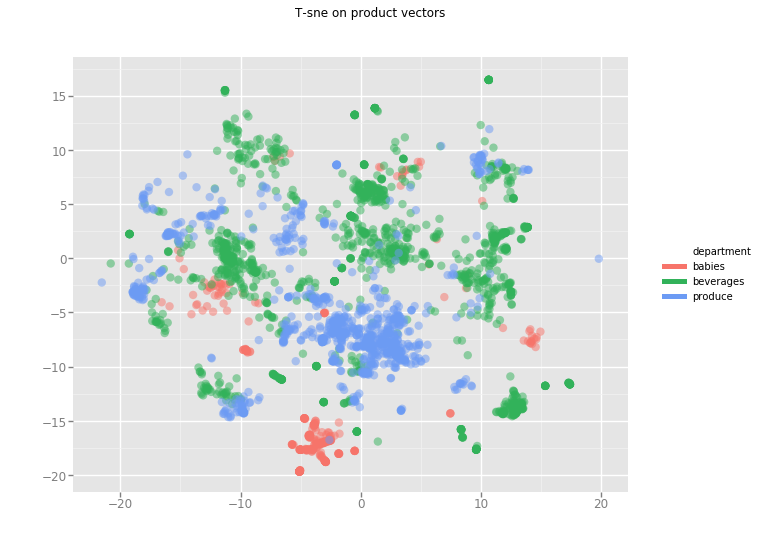

<ggplot: (8769285300365)>

In [87]:
tsne_plot = ggplot(tsne_plot_df, aes(x = "x_tsne", y = "y_tsne", color = "department") ) \
        + geom_point(size = 70, alpha = 0.5) \
        + ggtitle("T-sne on product vectors") \
        + xlab(" ") + ylab(" ")
tsne_plot

---

## In-class exercise

## Learning embeddings using Skip-gram

- We will now use another method to train embeddings called skip-gram

In [88]:
#===============================================
# model parameters
#===============================================

# size of embedding matrix
emb_size  # set between 50-100

# context window size
cxt_window # set between 2-10 

# batch size for gradient update
batch_size # set between 2000 to 10000

# learning rate
lr # set between 0.001 to 0.01

0.05

In [89]:
#===============================================
# define and train model
#===============================================

t0 = time.time()
### Write model code here
t1 = time.time()

In [90]:
# time taken
f"Time Taken: {t1 - t0}"

'Time Taken: 4.172325134277344e-05'

In [91]:
# find the most similar products to 
prod_id = "1000"

# product info for sample product
display(products.loc[products["product_id"].isin([prod_id]), :])

,product_id,product_name,aisle_id,department_id,aisle,department
